In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import (ConvLearner, TfmType, CropType, Flatten, VV,
                                 ImageClassifierData, RandomFlip, RandomRotate,
                                 RandomLighting, RandomDihedral,
                                 tfms_from_model, resnet50, optim, nn)
from fastai.dataset import to_np

import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from PIL import ImageDraw, ImageFont
from matplotlib import pyplot as plt
from matplotlib import patches, patheffects

In [3]:
PATH = Path('C:/Datasets/localization/')

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_bb(ax, b):
    patch = ax.add_patch(patches.Rectangle([b[0], b[2]], b[1] - b[0], b[3] - b[2], fill=False, edgecolor='white', lw=2))
    patch.set_path_effects([patheffects.Stroke(linewidth=3, foreground='black'), patheffects.Normal()])

### Generate `bb_csv` as per requirements

In [6]:
df = pd.read_csv('C:/Datasets/localization/training_aug_2.csv')

In [7]:
df.shape

(210000, 5)

In [9]:
bbox = []
for index, row in tqdm(df.iterrows()):
    bbox.append(' '.join([str(row['x1']), str(row['y1']), str(row['x2']), str(row['y2'])]))

210000it [00:15, 13907.61it/s]


In [10]:
len(bbox)

210000

In [11]:
df_aug = df.copy()
df_aug.drop(['x1', 'x2', 'y1', 'y2'], axis=1, inplace=True)
df_aug['bbox'] = bbox
df_aug.head()

image_name             bbox
0             JPEG_20160706_121146_1000145715002.png  115 143 495 325
1             JPEG_20161119_174038_1000690577600.png    23 61 457 409
2  147444927651111470309333776-Roadster-Men-Casua...    37 13 601 470
3                   147772332675720161028_161611.png   27 162 602 385
4                   1473315333651DeeplearnS11638.png   60 174 586 325

In [12]:
df.head()

image_name   x1   x2   y1   y2
0             JPEG_20160706_121146_1000145715002.png  115  495  143  325
1             JPEG_20161119_174038_1000690577600.png   23  457   61  409
2  147444927651111470309333776-Roadster-Men-Casua...   37  601   13  470
3                   147772332675720161028_161611.png   27  602  162  385
4                   1473315333651DeeplearnS11638.png   60  586  174  325

In [13]:
df_aug.to_csv('C:/Datasets/localization/training_aug_bb.csv', index=False)

### Define the regressor

In [5]:
base = resnet50
size = 224
batch_size = 16

In [6]:
bb_csv = PATH/'training_aug_bb.csv'
tfm_y = TfmType.NO
augs = []
tfms = tfms_from_model(base, size, crop_type=CropType.NO, aug_tfms=augs)
datagen = ImageClassifierData.from_csv(PATH, 'train_aug', bb_csv, test_name='test', tfms=tfms, bs=batch_size, continuous=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


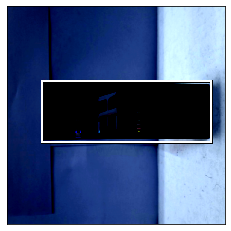

In [7]:
ix = 167992
im = datagen.trn_ds[ix][0].transpose([1, 2, 0])
ax = show_img(im)
bb = datagen.trn_ds[ix][1] * [224/640, 224/480, 224/640, 224/480]
draw_bb(ax, [bb[0], bb[2], bb[1], bb[3]])

In [8]:
print(f'{len(datagen.trn_ds)} training samples, \n {len(datagen.val_ds)} validation samples, \n{len(datagen.test_ds)} testing samples')

168000 training samples, 
 42000 validation samples, 
12815 testing samples


In [9]:
for i in tqdm(datagen.trn_ds):
    a = i[1]
    a[0] *= 224/640
    a[1] *= 224/480
    a[2] *= 224/640
    a[3] *= 224/480

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168000/168000 [38:54<00:00, 71.97it/s]


In [10]:
for i in tqdm(datagen.val_ds):
    a = i[1]
    a[0] *= 224/640
    a[1] *= 224/480
    a[2] *= 224/640
    a[3] *= 224/480

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42000/42000 [09:33<00:00, 72.14it/s]


In [11]:
head = nn.Sequential(Flatten(), nn.Linear(100352, 4))
learn = ConvLearner.pretrained(base, datagen, custom_head=head)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

 37%|██████████████████████████████████████████▏                                                                      | 3917/10500 [05:46<06:59, 15.70it/s, loss=37.7]

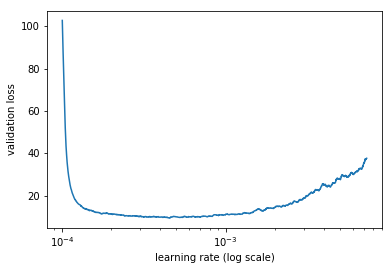

In [12]:
learn.lr_find(1e-4, 10)
learn.sched.plot(5)

In [13]:
lr = 2.4e-3 # tempering learning rate

In [14]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                                                                        
    0      6.142284   6.174294  
    1      11.249696  9.951068                                                                                                                                        
    2      4.961714   5.264909                                                                                                                                        


[array([5.26491])]

In [15]:
learn.freeze_to(-2)

 85%|███████████████████████████████████████████████████████████████████████████████████████████████▌                 | 8876/10500 [28:55<04:43,  5.73it/s, loss=25.7]

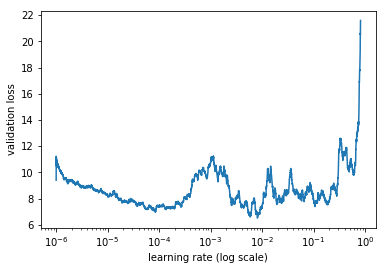

In [16]:
lr = 1e-3
lrs = np.array([lr/100, lr/10, lr])
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [17]:
lr = 1e-3 # safe lr for first 3 restarts (4 cycles)

In [18]:
learn.save('r50_v2.0')

In [19]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                                                                        
    0      2.772614   2.750031  
    1      2.885977   2.806096                                                                                                                                        
    2      1.869416   2.031863                                                                                                                                        
    3      2.868816   2.546507                                                                                                                                        
    4      2.065768   2.984255                                                                                                                                        
    5      1.433846   2.066678                                                                                                      

[array([2.61306])]

In [20]:
learn.save('r50_v2.1')

In [21]:
learn.fit(1e-4, 3, cycle_len=1, cycle_mult=2, best_save_name='r50_v2.2gg')

epoch      trn_loss   val_loss                                                                                                                                        
    0      0.723942   2.976203  
    1      0.645634   4.149245                                                                                                                                        
    2      0.552301   1.960949                                                                                                                                        
    3      0.617531   2.237264                                                                                                                                        
    4      0.59373    3.056544                                                                                                                                        
    5      0.501405   1.740671                                                                                                      

[array([2.04322])]

Very important: Train r50_v2.0 as well as r50_v2.1 separately, take the ensemble.

In [22]:
learn.load('r50_v2.2gg')

In [12]:
learn.load('r50_v2.0')

In [13]:
learn.fit(1e-3, 4, cycle_len=1, cycle_mult=2, best_save_name='r50_v2.0.1gg')

epoch      trn_loss   val_loss                                                                                                                                        
    0      4.561082   4.926116  
    1      6.813911   6.344884                                                                                                                                        
    2      3.828848   4.390236                                                                                                                                        
    3      7.355413   8.821399                                                                                                                                        
    4      5.753279   6.34864                                                                                                                                         
    5      3.958907   4.475925                                                                                                      

[array([3.60584])]

### New model starts here

In [14]:
head = nn.Sequential(Flatten(), nn.Linear(100352, 4))
learn = ConvLearner.pretrained(base, datagen, custom_head=head)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

 36%|█████████████████████████████████████████▏                                                                       | 3822/10500 [05:33<07:37, 14.61it/s, loss=37.8]

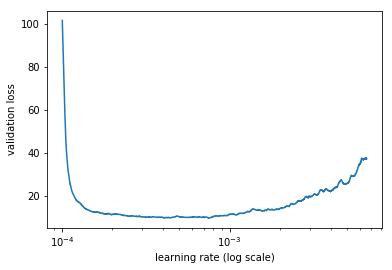

In [15]:
learn.lr_find(1e-4, 10)
learn.sched.plot(5)

In [16]:
lr = 2.4e-3 # tempering learning rate

In [17]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                                                                        
    0      6.163307   6.1616    
    1      11.212863  10.543501                                                                                                                                       
    2      4.978526   5.278699                                                                                                                                        


[array([5.2787])]

In [18]:
learn.save('r50_v3.0.0')

In [19]:
learn.freeze_to(-2)

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████             | 9303/10500 [30:18<03:55,  5.09it/s, loss=26.1]

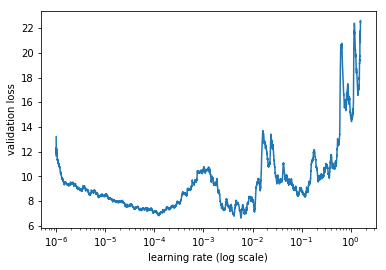

In [20]:
lr = 1e-3
lrs = np.array([lr/100, lr/10, lr])
lrf = learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [21]:
lr = 1e-3 # safe lr for first 3 restarts (4 cycles)

In [22]:
learn.save('r50_v3.0.1')

In [23]:
learn.fit(lr, 4, cycle_len=1, cycle_mult=2, best_save_name='r50_v3.0.1gg')

epoch      trn_loss   val_loss                                                                                                                                        
    0      2.711579   2.724285  
    1      2.938363   3.272419                                                                                                                                        
    2      2.156985   2.473256                                                                                                                                        
    3      2.504376   2.469268                                                                                                                                        
    4      2.129491   1.967232                                                                                                                                        
    5      1.54445    1.776544                                                                                                      

[array([1.02831])]

In [28]:
learn.load('r50_v3.0.1gg_noice')

In [29]:
def create_submission():
    flip = []
    for i, data in enumerate(tqdm(datagen.test_dl)):
        x, y = data
        learn.model.eval()
        preds = to_np(learn.model(VV(x)))
        for b in preds:
            flip.append([b[0]*640/224, b[2]*640/224, b[1]*480/224, b[3]*480/224])
    flip = np.array(flip)
    for i in tqdm(flip):
        if i[0] < 0:
            i[0] = 0.45
        if i[1] > 640:
            i[1] = 639.55
        if i[2] < 0:
            i[2] = 0.45
        if i[3] > 480:
            i[3] = 479.55
    dic = {x: y for x, y in zip(datagen.test_ds.fnames, flip)}
    df = pd.read_csv('C:/Datasets/localization/test.csv')
    fn = np.array(df['image_name'])
    _r = []
    for i in tqdm(fn):
        a = 'test\\' + i
        _r.append((i, dic[a]))
    _t = []
    for i in tqdm(_r):
        x, y = i
        a = [x] + list(y)
        _t.append(a)
    out = {x: y for x, y in enumerate(_t)}
    final = pd.DataFrame.from_dict(out, orient='index', columns=['image_name', 'x1', 'x2', 'y1', 'y2'])
    final.to_csv('C:/Datasets/localization/sub_aug_2.csv', index=False)

In [30]:
create_submission()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12815/12815 [00:00<00:00, 376775.27it/s]


In [31]:
df = pd.read_csv(PATH/'sub_aug_2.csv')
df.head()

image_name          x1          x2          y1  \
0               1474723840903DSC08089.png  232.015969  443.810032   88.192945   
1        1473231475010DeeplearnS11276.png   81.118905  570.180185  141.358419   
2  JPEG_20161205_135307_1000155917326.png  142.969077  493.991830   50.419141   
3  JPEG_20160711_123440_1000518778437.png  208.533194  466.508571   94.940750   
4   JPEG_20160803_115329_100034020722.png  134.709636  501.504604   40.964907   

           y2  
0  400.865446  
1  348.598676  
2  438.565096  
3  416.194382  
4  427.189538